<h3>Introducción</h3>
En este Notebook se utilizará el código <a href = "https://github.com/feos-org/feos"> $\mathrm{FeO_s}$</a> v0.3.0 para simular la adsorción de hidrógeno puro mediante la Teoría del Funcional de la Densidad Clásica. Para esto se necesita tener instalado el código $\mathrm{FeO_s}$, así como, numpy y matplotlib.

In [1]:
from feos.si import *     
from feos.pcsaft import * 
from feos.dft import *    

import numpy as np 
import matplotlib.pyplot as plt 

Debido a que en el Notebook anterior se mostró como determinar los parámetros SAFT, en este Notebook se utilizan directamente. Lo primero es definir el compuesto "methane" de acuerdo a lo mostrado <a href = "https://github.com/feos-org/feos/blob/main/examples/pcsaft_working_with_parameters.ipynb"> aquí</a>.

In [2]:
m=1.0 
s=3.712
e=150.80

identifier = Identifier(name='methane')
psr = PcSaftRecord(m, s, e)
methane = PureRecord(identifier, molarweight=16.04, model_record=psr)
parameters = PcSaftParameters.new_pure(methane)
parameters

|component|molarweight|$m$|$\sigma$|$\varepsilon$|$\mu$|$Q$|$\kappa_{AB}$|$\varepsilon_{AB}$|$N_A$|$N_B$|
|-|-|-|-|-|-|-|-|-|-|-|
|methane|16.04|1.025|3.675|149|0|0|0|0|1|1|

Luego se define el funcional a utilizar, en este caso se utiliza el funcional "WhiteBear" para PC-SAFT. También existe la posibilidad de utilizar el funcional "AntiSymWhiteBear" o "KierlikRosinberg".

In [3]:
func = HelmholtzEnergyFunctional.pcsaft(parameters, FMTVersion.WhiteBear)

Una vez definido el funcional se pueden determinar los perfiles de densidad del hidrógeno. Para esto se emplea un "solver" que realizará la iteración de Piccard con un coeficiente de 0.05, en general esto no es necesario modificar. El potencial del sólido se define en la variable "potential", se utiliza un potencial de Steele con $\sigma_{ss}$ = 3.4 Å,  $\varepsilon_{ss}/k_B$ = 28 K y $\rho_{s}$ = 0.114 Å$^3$ estos parámetros pueden ser modificados, al igual que el potencial escogido <a href = "https://feos-org.github.io/feos/api/generated/feos.dft.ExternalPotential.html#feos.dft.ExternalPotential"> (Steele, Lennard-Jones)</a>.

La temperatura de la adsorción y el tamaño del poro se definen en "temp" y "psize", respectivamente. El código $\mathrm{FeO_s}$ utiliza magnitudes con unidades físicas del SI por lo que deben multiplicarse por "KELVIN" y "ANGSTROM", como puede observarse en este <a href = "https://github.com/feos-org/feos/blob/main/examples/core_working_with_units.ipynb"> ejemplo</a>, lo mismo ocurre para la presión que debe multiplicarse por "BAR".

Para obtener los perfiles a diferentes presiones se usa "for" para las diferentes presiones. "bulk" utiliza la función `State` para obtener el estado termodinámico del compuesto en el seno, esta función requiere que se especifique la ecuación de estado a utilizar junto con su funcional (func), la temperatura (temp) y la presión, en este caso se utilizan 5 presiones diferentes [1, 35, 47, 80, 200].

Luego en "pore" se utiliza la función `Pore1D` para definir el poro tipo hendidura, para esto se debe especificar la geometría (Geometry.Cartesian), el tamaño de poro (Psize) y el potencial del sólido a usar (potential). Despues en "porex" se resuelve la distribucion de las densidades del compuesto al interior del poro, utilizando "solver" y "bulk" como primera aproximación.
Se puede investigar el uso de diferentes geometrías según este <a href = "https://github.com/feos-org/feos/blob/main/examples/pcsaft/pore_geometry.ipynb"> ejemplo</a>, pero esto no siempre da buenos resultados.

En "porex" se almacenan las densidades y la posición (z) del compuesto. La posición se obtiene con "porex.z" y la densidad con "porex.density", para graficar ambas hay que volverlas adimensionales, por lo que se debe dividir por sus unidades correspondientes. De esta forma, se obtienen los perfiles de densidad.

En este gráfico se agranda el tamaño del poro para demostrar que la densidad del compuesto en la mitad del poro (lo suficientemente lejos del potencial externo) corresponde a la densidad en el seno del fluido. Los datos para realizar la comparación fueron tomados del <a href = "https://webbook.nist.gov/cgi/fluid.cgi?ID=C74828&Action=Page"> NIST</a>.

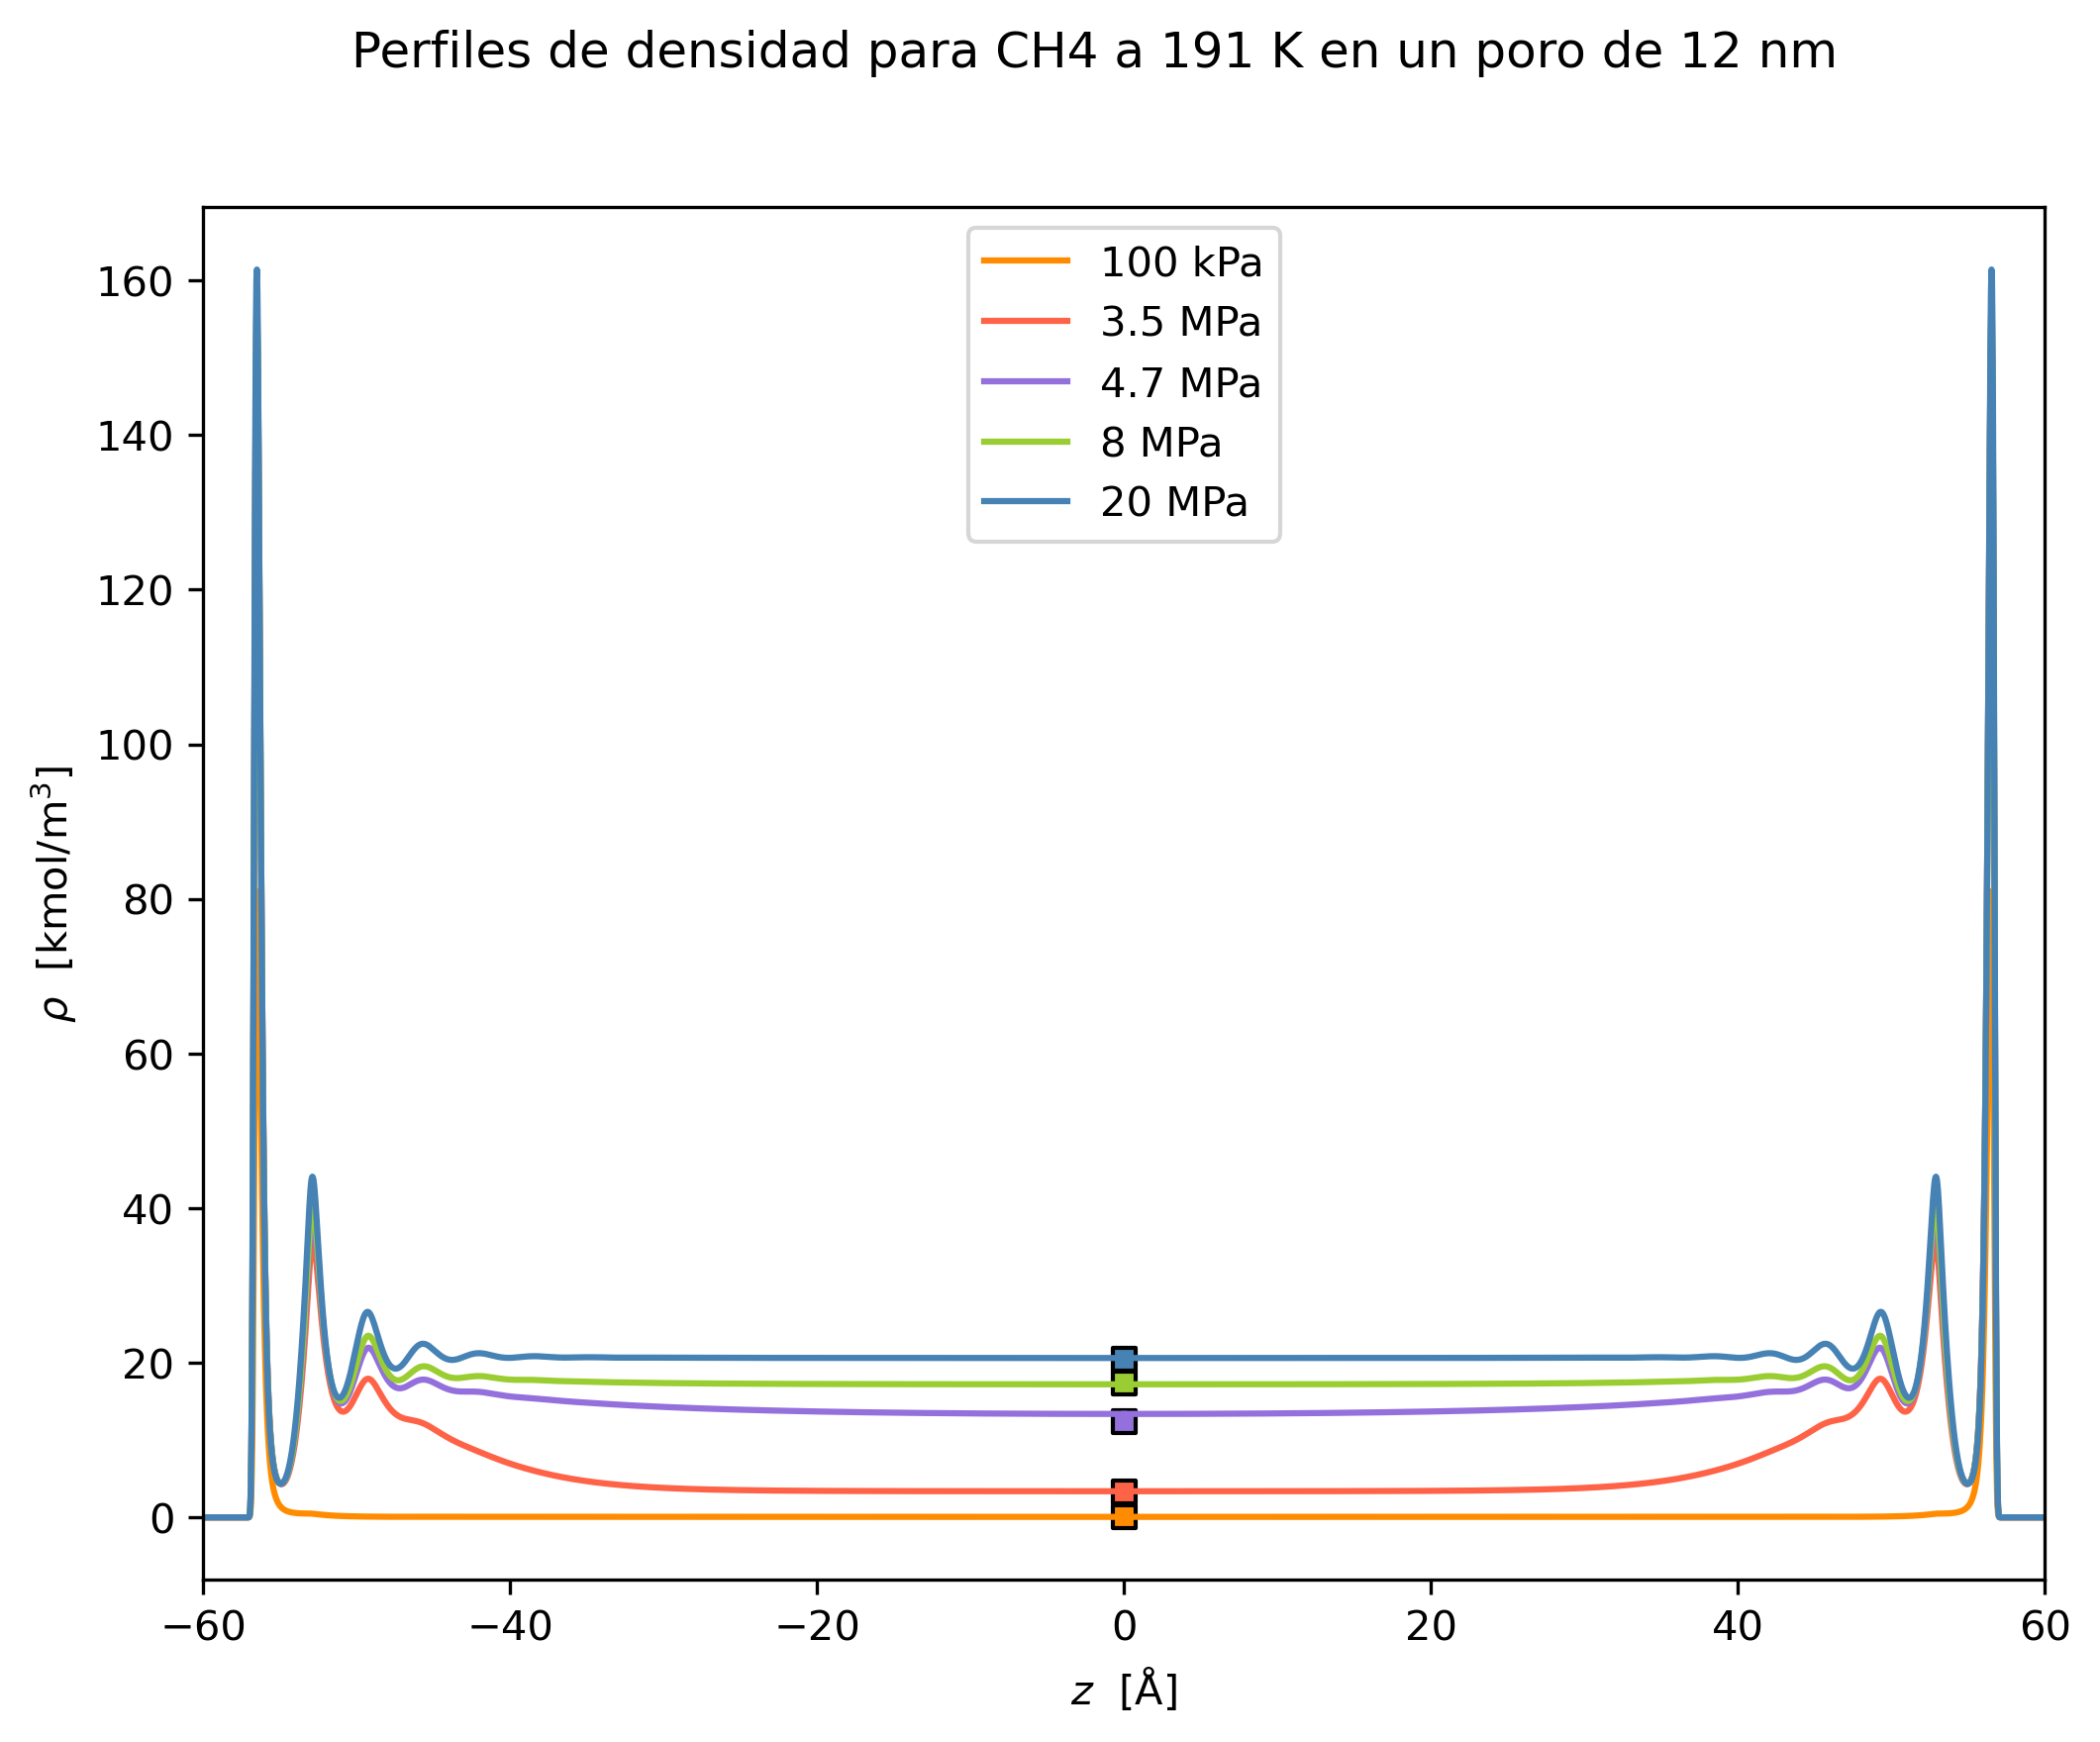

In [4]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

temp = 191*KELVIN
psize= 120*ANGSTROM

solver = DFTSolver().picard_iteration(tol=1e-5, beta=0.05).anderson_mixing()

potential = ExternalPotential.Steele(3.40, 28.0, 0.114)  # https://doi.org/10.1021/la803666t

colors = ["darkorange", "tomato", "mediumpurple", "yellowgreen", "steelblue"]

for j, i in enumerate([1, 35, 47, 80, 200]):
    bulk = State(func, temp, pressure=i*BAR)
    pore = Pore1D(Geometry.Cartesian, psize, potential)
    porex = pore.initialize(bulk).solve(solver)
    
    plt.plot(porex.z/(ANGSTROM), (porex.density*(METER**3/MOL)/1000).T, color=colors[j],
         label="{}".format(i * BAR))
    plt.plot(-porex.z/(ANGSTROM), (porex.density*(METER**3/MOL)/1000).T, color=colors[j])

cer=[0,0,0,0,0]
den=[0.063429,3.2978,12.432,17.406,20.502]
plt.scatter(cer, den, marker='s', color=colors, s=30, linewidths=1, edgecolor="k")   

plt.legend(loc="best", numpoints=1)  
plt.xlabel(r"$z$  [Å]")
plt.ylabel(r"$\rho$  [kmol/m$^3$]")
plt.xlim(-60, 60)
plt.suptitle('Perfiles de densidad para CH4 a {} en un poro de {}'.format(temp, psize))
plt.show()

A continuación se muestra la comparación realizada con los resultados de <a href = "https://doi.org/10.1016/j.cej.2021.131495"> Ghasemzadeh $et$ $al.$</a>. Para obtener los valores se utilizó un software de captura de datos.

In [5]:
Ghasemzadeh_z17=[-0.553,-0.519,-0.500,-0.460,-0.355,-0.219,-0.141,0.001,0.143,0.232,0.337,0.455,0.500,0.528,0.556]
Ghasemzadeh_a17=[0.000,1.253,1.582,0.840,0.129,0.227,0.402,0.247,0.402,0.201,0.119,0.727,1.588,0.582,0.005]
Ghasemzadeh_Z17 = np.multiply(Ghasemzadeh_z17,10)

Ghasemzadeh_z15=[-0.454,-0.421,-0.406,-0.386,-0.352,-0.245,-0.154,-0.056,0.016,0.094,0.206,0.338,0.378,0.407, 0.430, 0.450]
Ghasemzadeh_a15=[-0.010, 0.902, 1.541, 1.515, 0.727, 0.108, 0.108, 0.438, 0.572, 0.263, 0.093, 0.521, 1.325, 1.510,0.418, 0.021]
Ghasemzadeh_Z15 = np.multiply(Ghasemzadeh_z15,10)

Ghasemzadeh_z10=[-0.202,-0.176,-0.167,-0.146, -0.134,-0.116,-0.089,-0.033,0.085,0.138,0.153,0.180,0.190,0.203]
Ghasemzadeh_a10=[0.010, 1.015, 1.768, 1.985, 1.459, 0.716, 0.222, 0.041, 0.160, 1.428, 2.036, 1.057, 0.325, 0.026]
Ghasemzadeh_Z10 = np.multiply(Ghasemzadeh_z10,10)

Ghasemzadeh_z7=[-0.047,-0.026,-0.018, -0.013, -0.007,0.014, 0.026, 0.035, 0.052]
Ghasemzadeh_a7=[0.026, 0.954, 1.830, 2.716, 3.376, 2.954, 1.448, 0.521, 0.021]
Ghasemzadeh_Z7 = np.multiply(Ghasemzadeh_z7,10)

En este gráfico se sigue el mismo procedimiento que en el caso anterior cuidando de utilizar las mismas condiciones reportadas por <a href = "https://doi.org/10.1016/j.cej.2021.131495"> Ghasemzadeh $et$ $al.$</a> y transformando las unidades a $g/cm^3$. En este caso, los cálculos se hacen para diferentes tamaños de poros en vez de presiones.

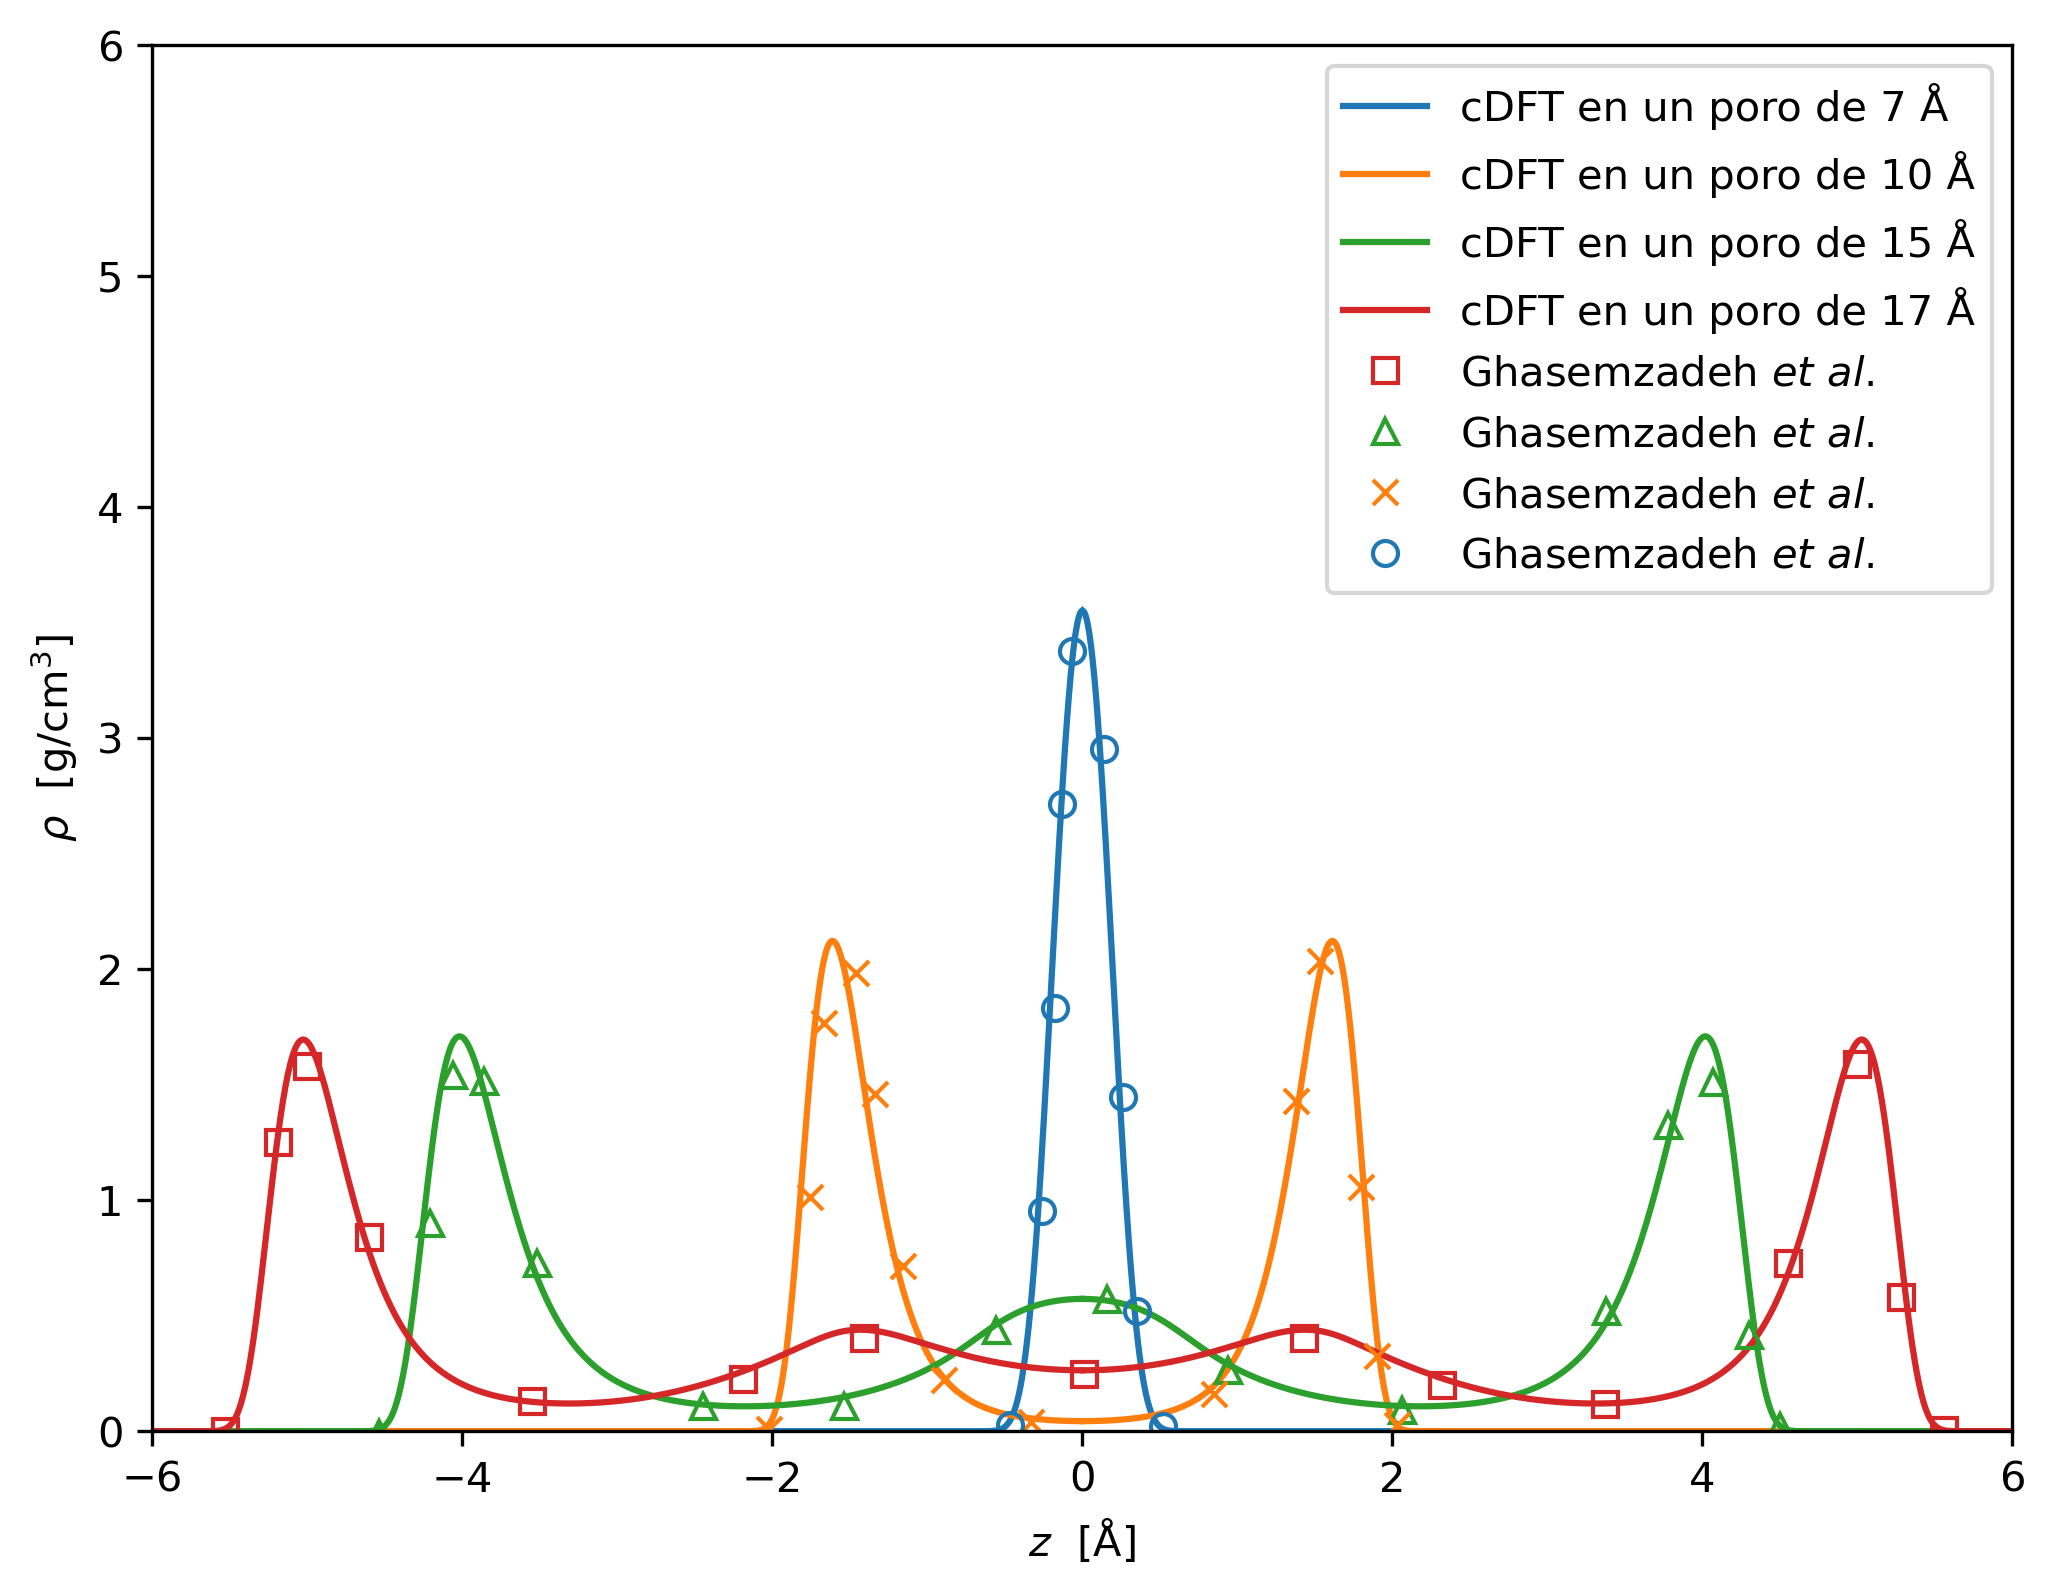

In [6]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

temp = 303.15*KELVIN
solver = DFTSolver().picard_iteration(tol=1e-5, beta=0.05).anderson_mixing()
potential = ExternalPotential.Steele(3.4, 28 , 0.114)  # https://doi.org/10.1021/la803666t

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "mediumpurple"]

for j, i in enumerate([7,10,15,17]):
    bulk = State(func, temp, pressure=400*BAR)
    porex = Pore1D(Geometry.Cartesian, i*ANGSTROM , potential).initialize(bulk).solve(solver)
    porex2= (porex.density*(METER**3/MOL)/1000).T

    plt.plot(porex.z/(ANGSTROM), porex2*16.04/1000, color=colors[j],
         label="cDFT en un poro de {} Å".format(i))
    plt.plot(-porex.z/(ANGSTROM), porex2*16.04/1000, color=colors[j])

plt.plot(Ghasemzadeh_Z17, Ghasemzadeh_a17, label="Ghasemzadeh $et$ $al.$", color="tab:red",
         marker="s", linestyle="None", mfc="None")    
plt.plot(Ghasemzadeh_Z15, Ghasemzadeh_a15, label="Ghasemzadeh $et$ $al.$", color="tab:green",
         marker="^", linestyle="None", mfc="None") 
plt.plot(Ghasemzadeh_Z10, Ghasemzadeh_a10, label="Ghasemzadeh $et$ $al.$", color="tab:orange",
         marker="x", linestyle="None", mfc="None") 
plt.plot(Ghasemzadeh_Z7,  Ghasemzadeh_a7, label="Ghasemzadeh $et$ $al.$", color="tab:blue",
         marker="o", linestyle="None", mfc="None") 

plt.legend(loc="best", numpoints=1)  
plt.xlabel(r"$z$  [Å]")
plt.ylabel(r"$\rho$  [g/cm$^3$]")
plt.xlim(-6,6)
plt.ylim(0, 6)
#plt.suptitle('Perfiles de densidad para CH4 a {} en un poro de {} A'.format(temp, (psize/ANGSTROM)))
plt.show()

Una vez obtenidos y comparados los perfiles de densidad, se determinaron las isotermas de adsorción. Para esto se deben seguir pasos similares a los anteriores, definiendo el tamaño de poro (pore_siz), el potencial del sólido (potential) y  la configuración del poro (pore). Luego se usa "for" para graficar las diferentes isotermas. 

"isotherm" utiliza la función `Adsorption1D.adsorption_isotherm` para calcular la isotermas de adsorción en un rango de presiones, esta función requiere que se especifique el funcional a utilizar (func), la temperatura (en el rango for), la presión (que debe ser un vector linspace definido especialmente por $\mathrm{FeO_s}$) y el poro (pore). De esta forma, las soluciones se almacenan en "isotherm".

Luego, para extraer las soluciones de "isotherm" se agrega `.pressure` para obtener la presión (p) y `.total_adsorption` para obtener la cantidad adsorbida (total), para graficar estas magnitudes hay que volverlas adimensionales, por lo que se debe dividir por sus unidades correspondientes.

A continuación se muestra la comparación realizada con los resultados de <a href = "https://iopscience.iop.org/article/10.1088/0953-8984/14/40/318/pdf"> Liang $et$ $al.$</a>. Para obtener los valores se utilizó un software de captura de datos y se transformaron las unidades de MPa a Bar. El área especifica (BET) está en $m^2/g$.

In [7]:
Liang_p333= [0.368, 0.745, 1.379, 2.067, 2.728, 3.403, 4.334, 5.103, 5.683, 6.209, 6.83, 7.342, 7.801, 8.327, 9.002]
Liang_a333= [1.15, 1.839, 2.581, 3.119, 3.499, 3.764, 4.038, 4.188, 4.294, 4.364, 4.435, 4.47, 4.497, 4.532, 4.576]
Liang_P333= np.multiply(Liang_p333,10)

Liang_p293X= [0.145, 1.267, 2.813, 4.244, 5.504, 6.935, 8.492, 9.363]
Liang_a293X= [1.61, 7.066, 10.016, 11.296, 12.02, 12.326, 12.382, 12.465]
Liang_P293X= np.multiply(Liang_p293X,10)

Liang_p333X= [0.168, 1.198, 2.538, 4.187, 6.008, 7.908, 9.363]
Liang_a333X= [0.859, 4.227, 6.592, 8.29, 9.348, 10.016, 10.266]
Liang_P333X= np.multiply(Liang_p333X,10)

Liang_p298= [0.055, 0.102, 0.508, 0.963, 1.987, 3.93, 5.75]
Liang_a298= [0.645, 1.086, 2.882, 3.959, 5.184, 6.098, 6.376]
Liang_P298 = np.multiply(Liang_p298,10)
ones1=np.linspace(1,1,len(Liang_a298))
Liang_A298= Liang_a298+np.multiply(ones1,7)

Debido a que cada sólido reportado por Liang tiene características diferentes se debe hacer un cálculo por separado para cada uno.

In [8]:
%%time
solver     = DFTSolver().picard_iteration(tol=1e-5, beta=0.05).anderson_mixing()
BET0       = 730.36
potential0 = ExternalPotential.Steele(3.4, 30, 0.114)  # https://doi.org/10.1021/la803666t
psize0     = 16.25 * ANGSTROM
presion0   = SIArray1.linspace(1.0e-2 * BAR, 94*BAR, 100)
pore0      = Pore1D(geometry=Geometry.Cartesian, pore_size = psize0, potential = potential0)
porevol0   = pore0.pore_volume
nporevol0  = porevol0 / (METER)                       # m
temp0      = 333 * KELVIN
isotherm0  = Adsorption1D.adsorption_isotherm(func, temperature = temp0, pressure = presion0, pore = pore0)
p0 = isotherm0.pressure / BAR
total_adsorption0 = isotherm0.total_adsorption / (MICRO * MOL / METER**2)

Vrho0=[]
for i in p0:
    bulk0    = State(func, temp0, pressure = i*BAR)
    profile0 = Pore1D(Geometry.Cartesian, psize0, potential0).initialize(bulk0).solve(solver)
    densb0   = profile0.bulk.density
    ndensb0  = densb0 / ((MICRO * MOL) / METER**3)  # umol / m3
    VDens0   = np.multiply(ndensb0,nporevol0)        # umol /m2
    Vrho0.append(VDens0)
total_adsorption00 = np.multiply(total_adsorption0,BET0/1000)
Vrho00            = np.multiply(Vrho0,BET0/1000)

CPU times: user 23.4 s, sys: 180 ms, total: 23.6 s
Wall time: 24 s


In [9]:
%%time
BET1       = 1735
potential1 = ExternalPotential.Steele(3.34, 28, 0.114)  # https://doi.org/10.1021/la803666t
psize1     = 17.54 * ANGSTROM
presion1   = SIArray1.linspace(1.0e-2 * BAR, 94*BAR, 100)
pore1      = Pore1D(geometry=Geometry.Cartesian, pore_size = psize1, potential = potential1)
porevol1   = pore1.pore_volume
nporevol1  = porevol1 / (METER)                       # m
temp1      = 293.15 * KELVIN
isotherm1  = Adsorption1D.adsorption_isotherm(func, temperature = temp1, pressure = presion1, pore = pore1)
p1 = isotherm1.pressure / BAR
total_adsorption1 = isotherm1.total_adsorption / (MICRO * MOL / METER**2)

Vrho1=[]
for i in p1:
    bulk1    = State(func, temp1, pressure = i*BAR)
    profile1 = Pore1D(Geometry.Cartesian, psize1, potential1).initialize(bulk1).solve(solver)
    densb1   = profile1.bulk.density
    ndensb1  = densb1 / ((MICRO * MOL) / METER**3)  # umol / m3
    VDens1   = np.multiply(ndensb1,nporevol1)        # umol /m2
    Vrho1.append(VDens1)
total_adsorption11 = np.multiply(total_adsorption1,BET1/1000)
Vrho11             = np.multiply(Vrho1,BET1/1000)

CPU times: user 25.3 s, sys: 148 ms, total: 25.4 s
Wall time: 25.6 s


In [10]:
%%time
BET2       = 1735
potential2 = ExternalPotential.Steele(3.34, 28, 0.114)  # https://doi.org/10.1021/la803666t
psize2     = 17.54 * ANGSTROM
presion2   = SIArray1.linspace(1.0e-2 * BAR, 94*BAR, 100)
pore2      = Pore1D(geometry=Geometry.Cartesian, pore_size = psize2, potential = potential2)
porevol2   = pore2.pore_volume
nporevol2  = porevol2 / (METER)                       # m
temp2      = 333.15 * KELVIN
isotherm2  = Adsorption1D.adsorption_isotherm(func, temperature = temp2, pressure = presion2, pore = pore2)
p2 = isotherm2.pressure / BAR
total_adsorption2 = isotherm2.total_adsorption / (MICRO * MOL / METER**2)

Vrho2=[]
for i in p2:
    bulk2    = State(func, temp2, pressure = i*BAR)
    profile2 = Pore1D(Geometry.Cartesian, psize2, potential2).initialize(bulk2).solve(solver)
    densb2   = profile2.bulk.density
    ndensb2  = densb2 / ((MICRO * MOL) / METER**3)  # umol / m3
    VDens2   = np.multiply(ndensb2,nporevol2)        # umol /m2
    Vrho2.append(VDens2)
total_adsorption22  = np.multiply(total_adsorption2,BET2/1000)
Vrho22             = np.multiply(Vrho2,BET2/1000)

CPU times: user 23.2 s, sys: 148 ms, total: 23.4 s
Wall time: 23.5 s


In [11]:
%%time
BET3       = 824.18
potential3 = ExternalPotential.Steele(3.4, 36, 0.114)  # https://doi.org/10.1021/la803666t
psize3     = 16.36 * ANGSTROM
presion3   = SIArray1.linspace(1.0e-2 * BAR, 60*BAR, 100)
pore3      = Pore1D(geometry=Geometry.Cartesian, pore_size = psize3, potential = potential3)
porevol3   = pore3.pore_volume
nporevol3  = porevol3 / (METER)                       # m
temp3      = 298 * KELVIN
isotherm3  = Adsorption1D.adsorption_isotherm(func, temperature = temp3, pressure = presion3, pore = pore3)
p3 = isotherm3.pressure / BAR
total_adsorption3 = isotherm3.total_adsorption / (MICRO * MOL / METER**2)

Vrho3=[]
for i in p3:
    bulk3    = State(func, temp3, pressure = i*BAR)
    profile3 = Pore1D(Geometry.Cartesian, psize3, potential3).initialize(bulk3).solve(solver)
    densb3   = profile3.bulk.density
    ndensb3  = densb3 / ((MICRO * MOL) / METER**3)  # umol / m3
    VDens3   = np.multiply(ndensb3,nporevol3)        # umol /m2
    Vrho3.append(VDens3)
total_adsorption33  = np.multiply(total_adsorption3,BET3/1000)
Vrho33              = np.multiply(Vrho3,BET3/1000)

CPU times: user 24.5 s, sys: 152 ms, total: 24.7 s
Wall time: 24.8 s


Una vez calculados los sólidos con sus adsorciones se grafican todos juntos.

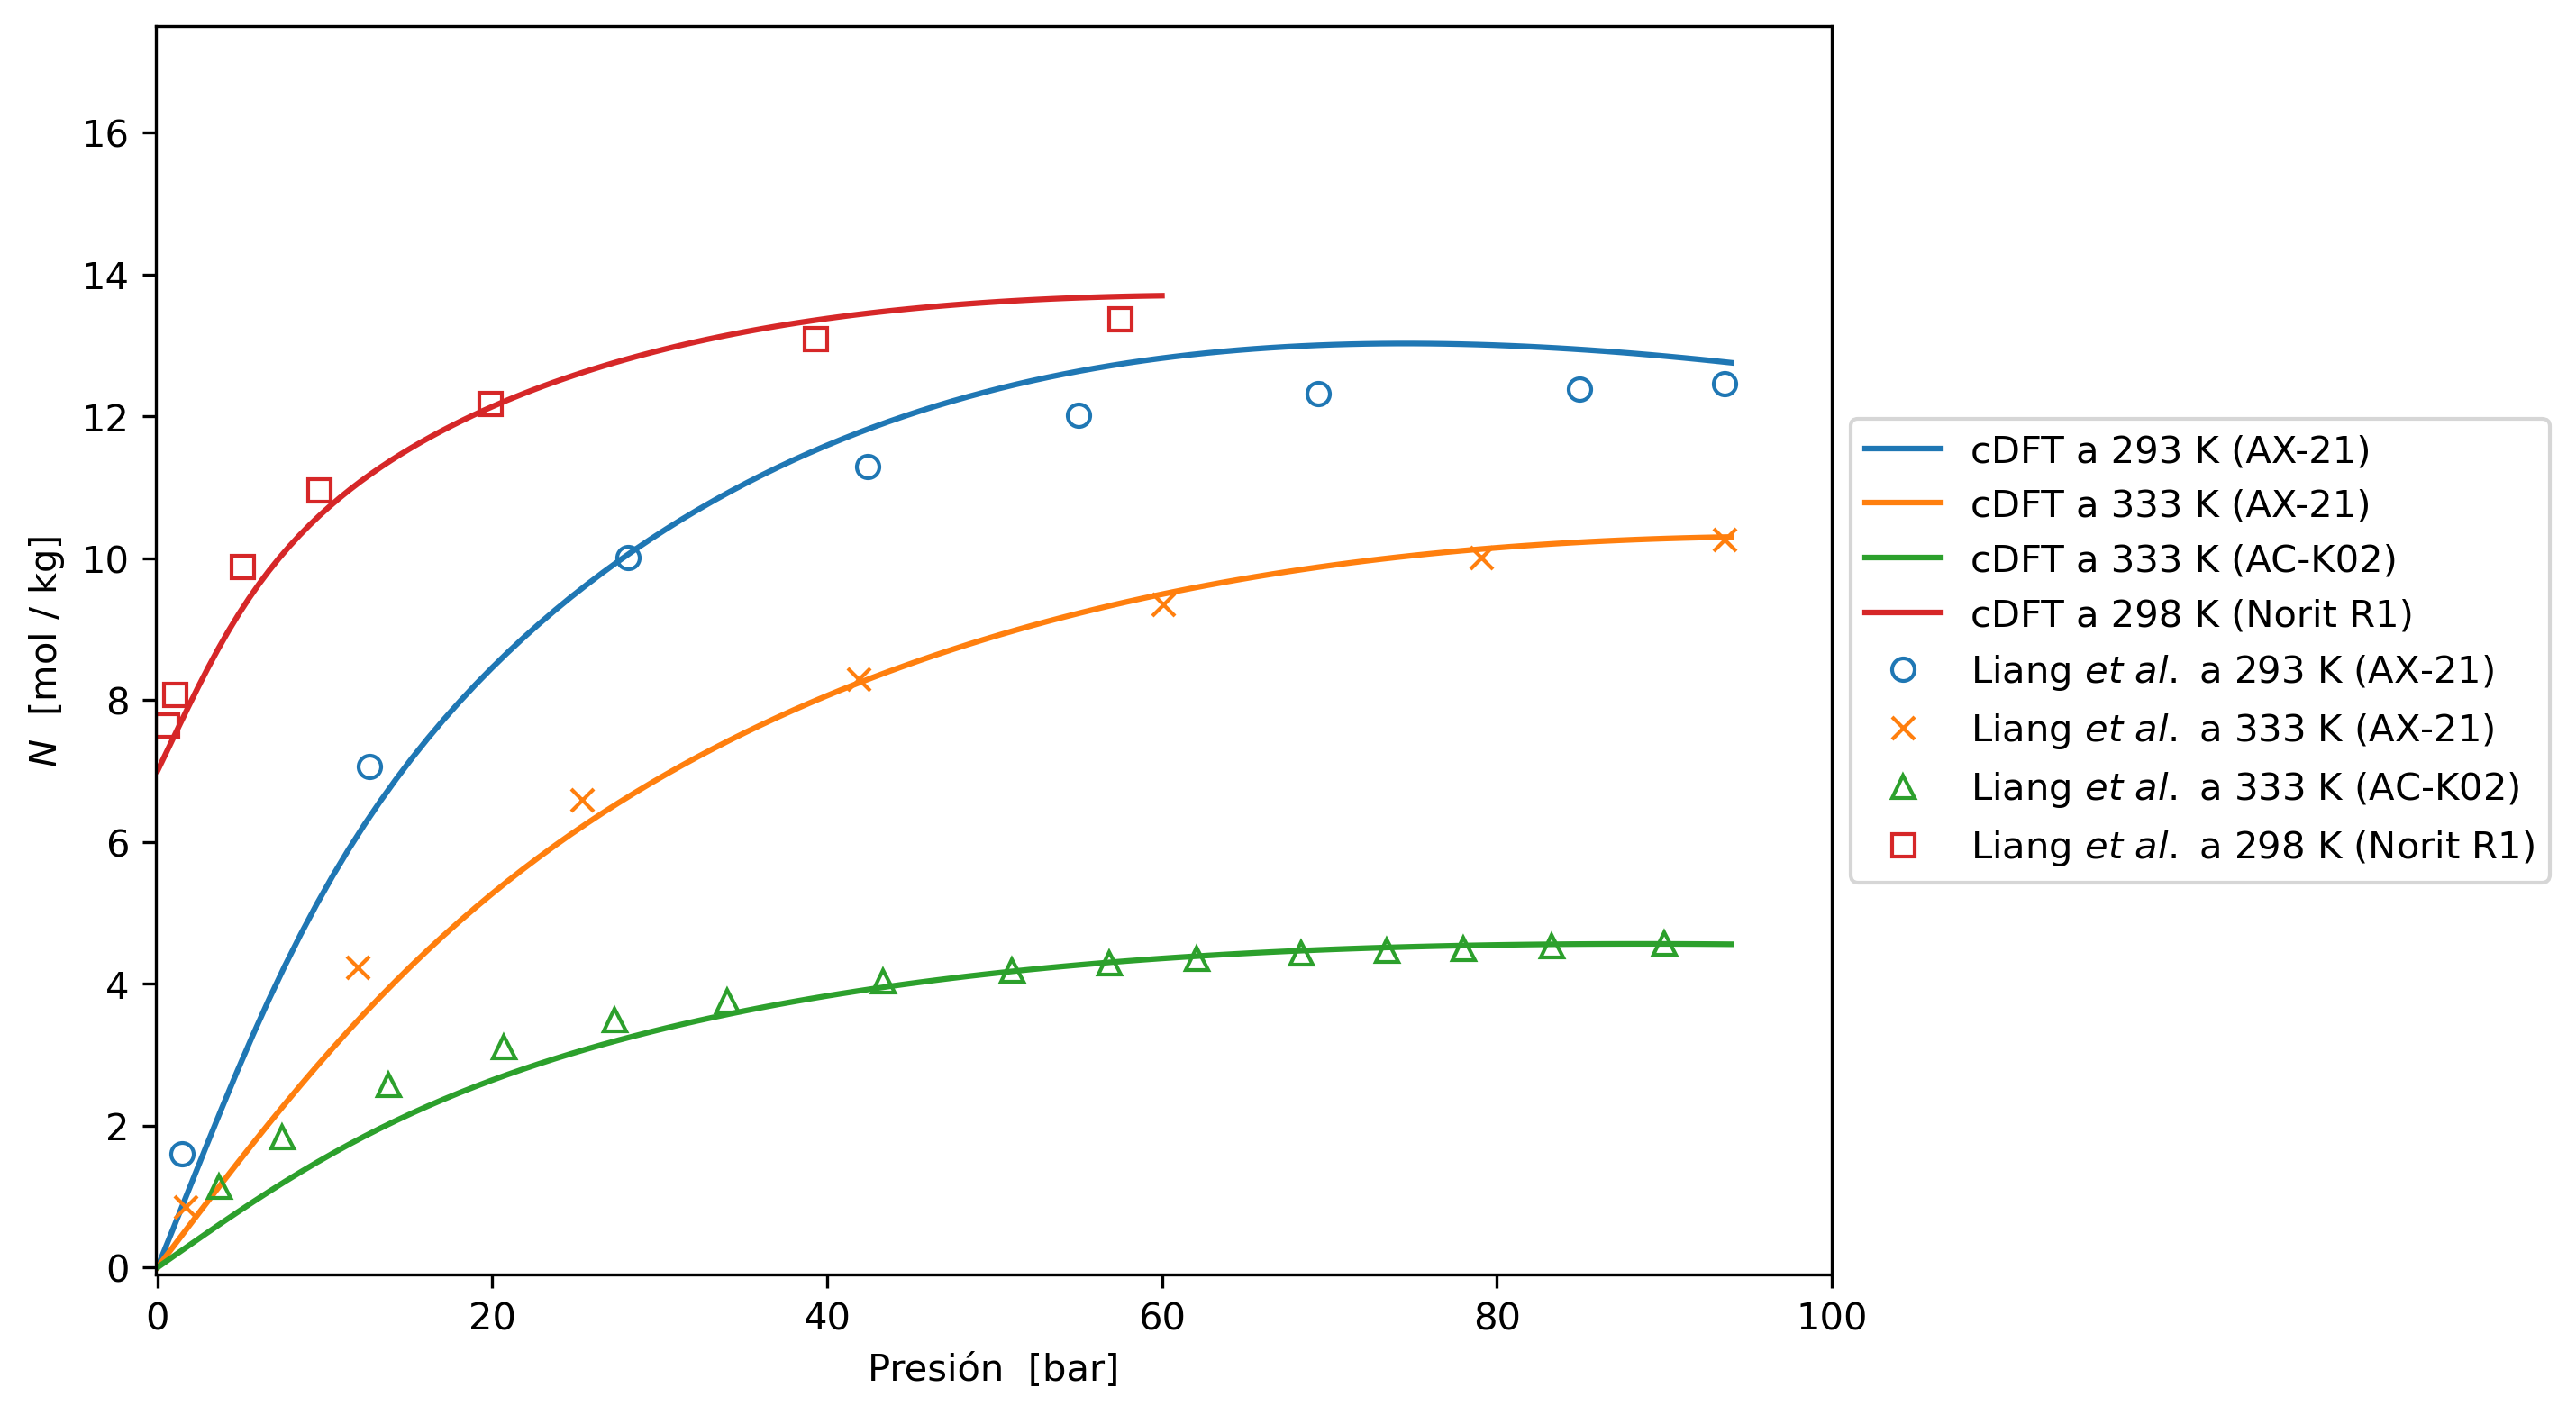

In [12]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

plt.plot(p1, total_adsorption11-Vrho11, label="cDFT a 293 K (AX-21)")

plt.plot(p2, total_adsorption22-Vrho22, label="cDFT a 333 K (AX-21)")

plt.plot(p0, total_adsorption00-Vrho00, label="cDFT a 333 K (AC-K02)")

plt.plot(p3, total_adsorption33-Vrho33+7, label="cDFT a 298 K (Norit R1)")

plt.plot(Liang_P293X, Liang_a293X, label="Liang $et$ $al.$ a 293 K (AX-21)", color="tab:blue",
         marker="o", linestyle="None", mfc="None")

plt.plot(Liang_P333X, Liang_a333X, label="Liang $et$ $al.$ a 333 K (AX-21)", color="tab:orange",
         marker="x", linestyle="None", mfc="None")

plt.plot(Liang_P333, Liang_a333, label="Liang $et$ $al.$ a 333 K (AC-K02)", color="tab:green",
         marker="^", linestyle="None", mfc="None")

plt.plot(Liang_P298, Liang_A298, label="Liang $et$ $al.$ a 298 K (Norit R1)", color="tab:red",
         marker="s", linestyle="None", mfc="None")

plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)   
plt.xlim(-0.1, 100)
plt.ylim(-0.1, 17.5)
plt.xlabel(r'Presión  [bar]')
plt.ylabel(r'$N$  [mol / kg]')
#plt.suptitle('Isotermas de adsorción para CH4 en un poro de {} a {}'.format(pore_siz,temp))
plt.show()
